In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.modules.loss import MSELoss
from torch.utils.data import dataloader
import utils
from arguments import parse_args
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

from IPython.display import clear_output as clear

%matplotlib inline
%load_ext autoreload
%autoreload 2

class LossLogger(object):
    def __init__(self, decay):
        self.loss_history = []
        self.loss = 0
        self.decay = decay
        
    def push(self, loss):
        self.loss_history.append(loss)
        self.loss *= self.decay
        self.loss += loss * (1-self.decay)
        
    def loss(self):
        return self.loss
    
    def flush(self):
        self.loss = 0

    def history(self):
        return self.loss_history
    
    
logger = LossLogger(0.8)

In [2]:
args = parse_args(["--alg", "MAE", "--description", "mae_pretrain_piconly", "--lr", "1e-2", "--epoch", "200", '--data_root', 'data/set5_simple', '--batch_size', '1'])

In [3]:
# Training Preparation
utils.set_seed_everywhere(271828)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

train_dataset = utils.TrainDataset_PictureOnly(args)
train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True)

loss_function = nn.MSELoss()

# loss_function = lambda img_gt, img_pred : -utils.psnr(img_gt, img_pred) - utils.ssim(img_gt, img_pred)

from models.vit import ViT
from models.mae import MAE

img_size, patch_size = (256, 256), (16, 16)

# encoder = ViT(img_size, patch_size, depth=12, dim=768, mlp_dim=3072, num_heads=12) # ViT-B/16
# encoder = ViT(img_size, patch_size, depth=24, dim=1024, mlp_dim=4096, num_heads=16) # ViT-L/16 (Default in MAE paper)
# encoder = ViT(img_size, patch_size, depth=32, dim=1280, mlp_dim=5120, num_heads=16) # ViT-H/16
encoder = ViT(img_size, patch_size, dim=512, mlp_dim=1024, dim_per_head=64) # Simple

# model = MAE(encoder, decoder_depth=8, decoder_dim=512, mask_ratio=0.75) # (Default in MAE paper)
model = MAE(encoder, decoder_depth=6, decoder_dim=512)
model.to(device)

optimizer = optim.RAdam(params=model.parameters(),lr=args.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1000,gamma = 0.5)

e = 0

cuda:0


In [4]:
print(len(train_loader))

391


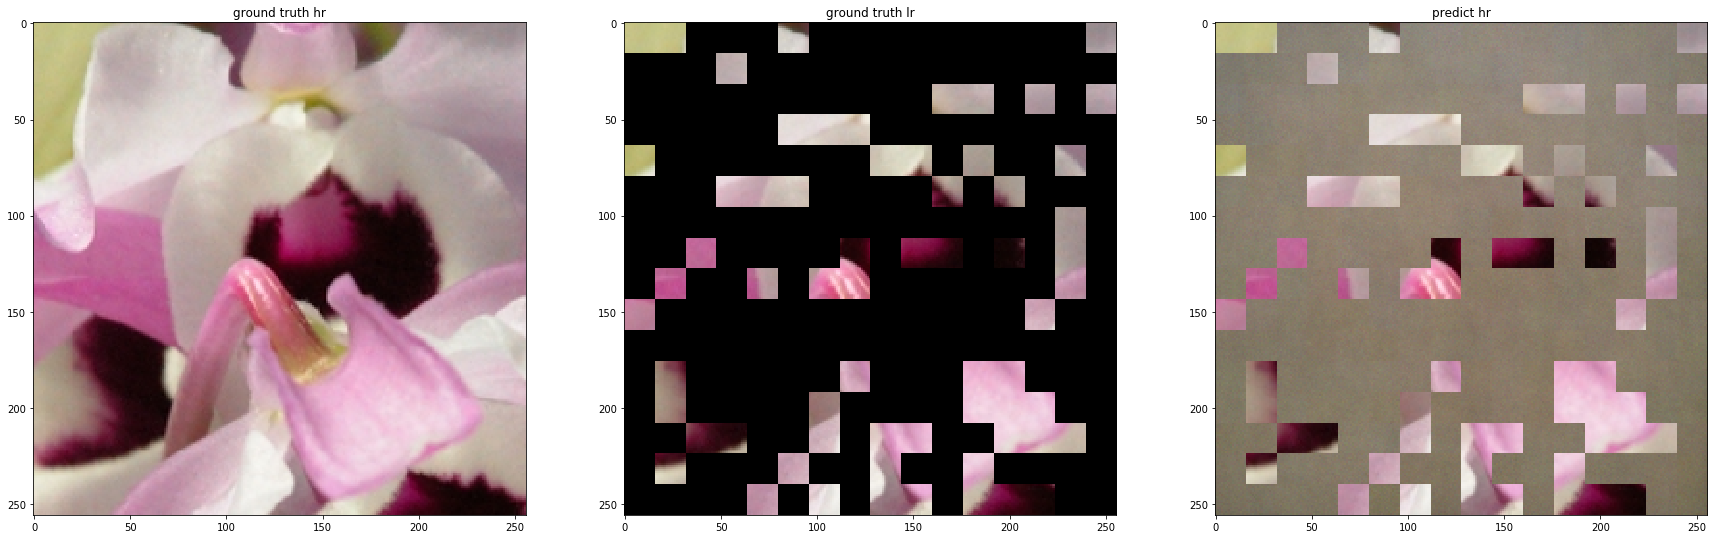

epoch: 32 | iter: 87/391 | loss: 0.06565572084423421:  23%|██▎       | 88/391 [00:18<01:03,  4.75it/s] 


KeyboardInterrupt: 

In [5]:
import random
# Start training
lr_list = []
model.train()

# for _ in range(800): # Default setting in MAE paper
for _ in range(100):
    idx = random.randint(0, len(train_dataset))
    img = train_dataset[idx].unsqueeze(0).to(device)
    utils.save_model(model, e, args)
    clear()
    recons_img, patches_to_img = model.predict(img)
    recons_img = recons_img[0].permute(1, 2, 0).cpu().numpy()
    patches_to_img = patches_to_img[0].permute(1, 2, 0).cpu().numpy()
    img_gt = img[0].permute(1, 2, 0).cpu().numpy()
    utils.show_gt_and_pred(img_hr=img_gt, img_lr=patches_to_img, pred_hr=recons_img, figsize=(30, 30))
    
    loop = tqdm.tqdm(train_loader)
    for idx, img in enumerate(loop):
        
        img = img.to(device)
        loss = model(img)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        
        logger.push(loss.item())
        loop.set_description(f"epoch: {e} | iter: {idx}/{len(train_dataset)} | loss: {logger.loss}")
    e += 1